In [26]:
import pandas as pd
import numpy as np
import multiprocessing
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn import metrics
import gc
from time import time
import datetime
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold,GroupKFold
from sklearn.metrics import roc_auc_score
warnings.simplefilter('ignore')
%matplotlib inline

In [47]:
df = pd.read_csv('Dataset/train.csv')
df.head()

,Customer_ID,marriage,sex,education,LIMIT_BAL,age,pay_0,pay_2,pay_3,pay_4,...,Bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,AVG_Bill_amt,PAY_TO_BILL_ratio,next_month_default
0,5017,2,0,2,60000,25.0,2,2,2,0,...,20750.63,2000.21,0.00,1134.85,1821.78,1500.03,1500.24,41511.50,0.03,0
1,5018,2,1,1,290000,24.0,0,0,-2,-2,...,1350.30,0.00,0.17,0.00,2700.10,0.00,1349.72,2534.50,0.27,0
2,5019,1,0,2,180000,63.0,0,0,0,0,...,52991.51,2086.94,2199.99,1845.66,2000.35,1923.00,1999.78,50422.00,0.04,0
3,5020,1,1,2,210000,43.0,0,0,0,0,...,76945.47,3348.07,3380.91,3400.45,2683.97,2744.00,2892.10,86229.50,0.04,0
4,5021,2,0,1,280000,32.0,-2,-2,-2,-2,...,1.35,999.78,3186.27,45027.78,2100.09,0.01,0.27,11814.33,0.72,0


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25247 entries, 0 to 25246
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer_ID         25247 non-null  int64  
 1   marriage            25247 non-null  int64  
 2   sex                 25247 non-null  int64  
 3   education           25247 non-null  int64  
 4   LIMIT_BAL           25247 non-null  int64  
 5   age                 25121 non-null  float64
 6   pay_0               25247 non-null  int64  
 7   pay_2               25247 non-null  int64  
 8   pay_3               25247 non-null  int64  
 9   pay_4               25247 non-null  int64  
 10  pay_5               25247 non-null  int64  
 11  pay_6               25247 non-null  int64  
 12  Bill_amt1           25247 non-null  float64
 13  Bill_amt2           25247 non-null  float64
 14  Bill_amt3           25247 non-null  float64
 15  Bill_amt4           25247 non-null  float64
 16  Bill

In [29]:
df.next_month_default.unique()

array([0, 1])

In [30]:
df.next_month_default.value_counts()

next_month_default
0    20440
1     4807
Name: count, dtype: int64

# Exploratory Data Analysis (EDA)

## 1) Univariate Analysis

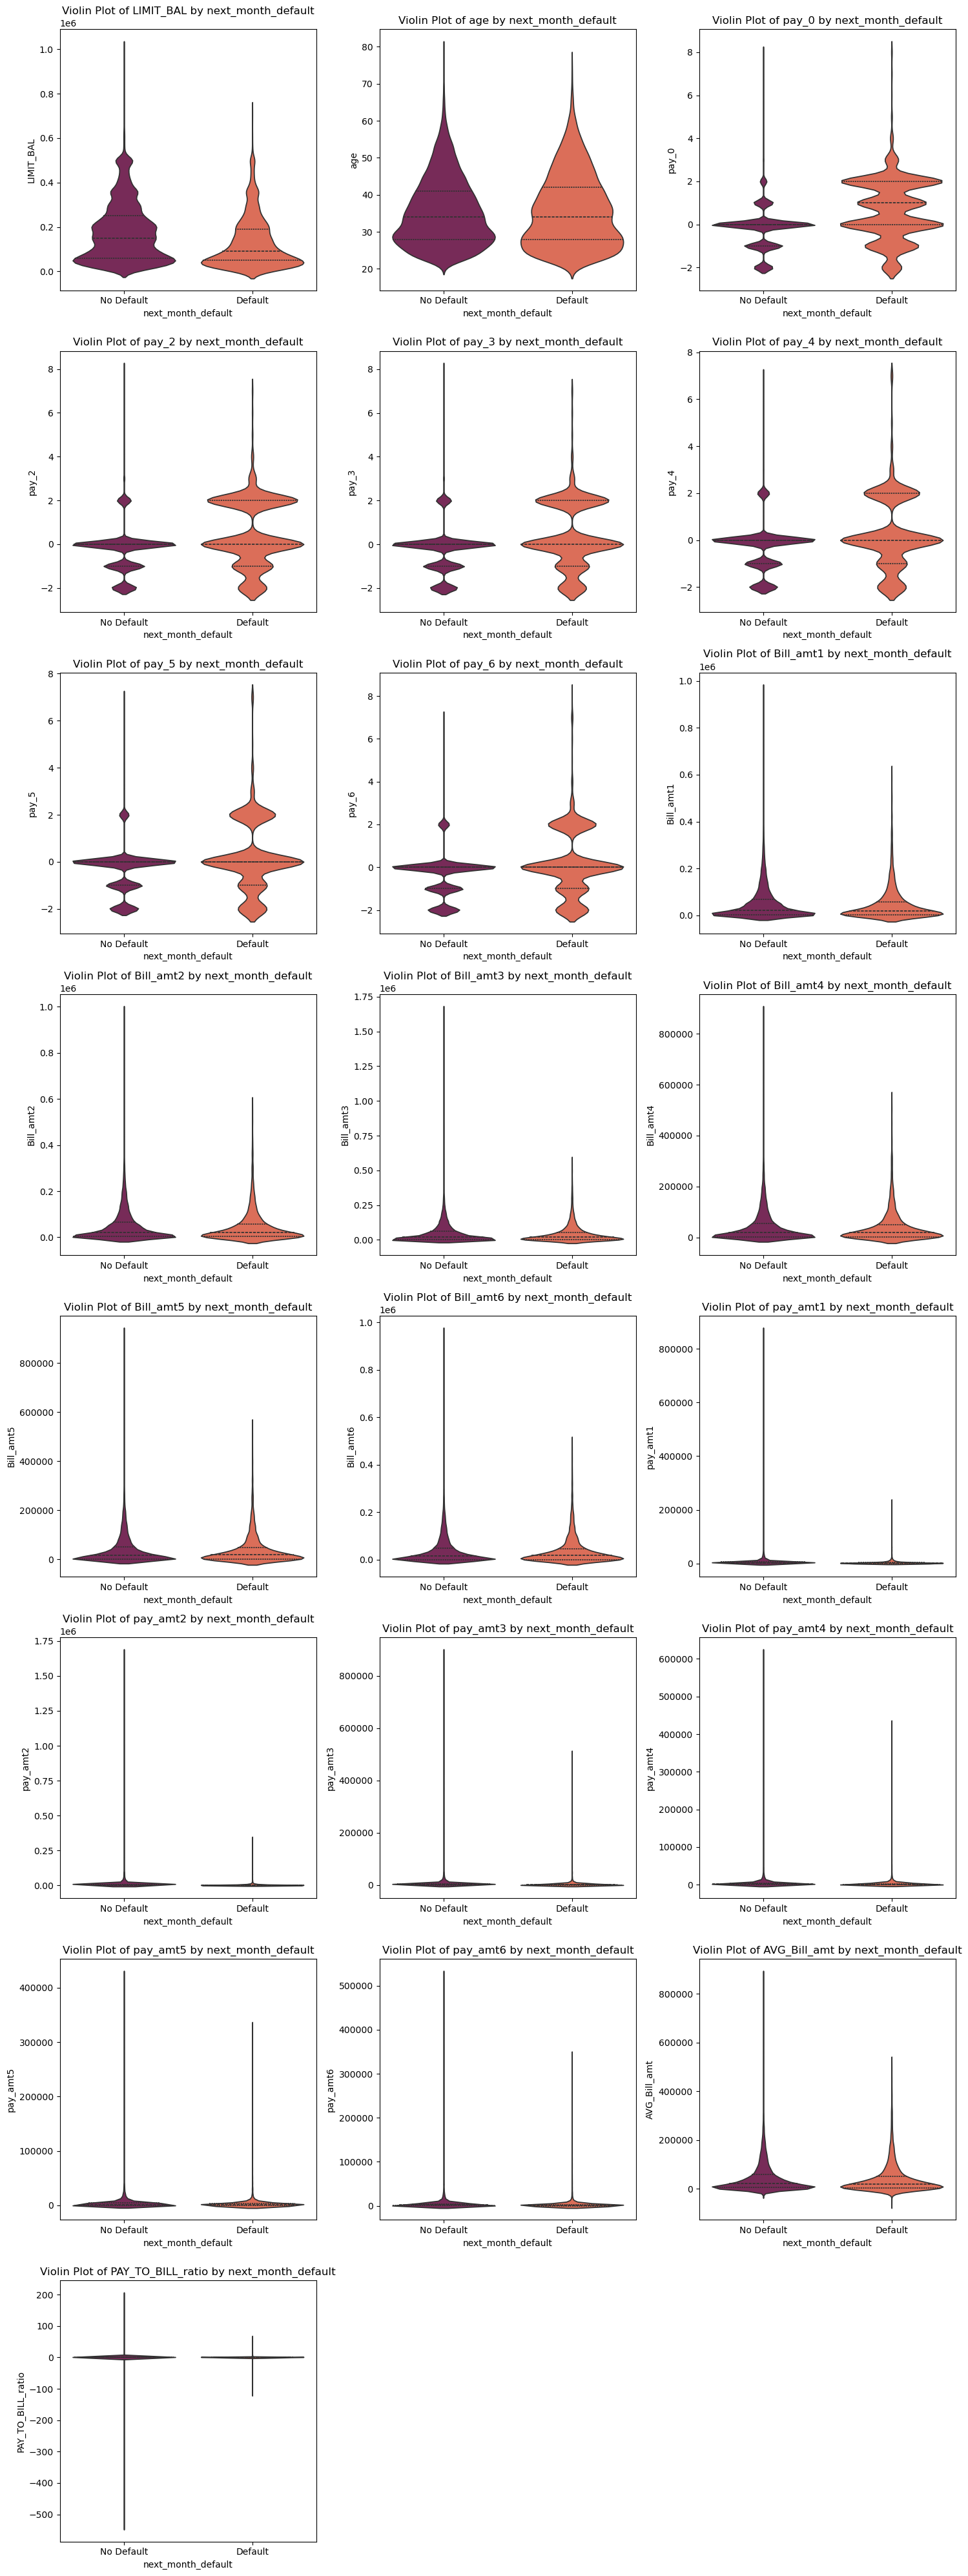

In [31]:
# Violin Plot for all the given numerical features
def plot_violin_plots(df, features):
    n = len(features)
    cols = 3
    rows = (n + cols - 1) // cols
    plt.figure(figsize=(15, 5 * rows))
    
    for i, col in enumerate(features):
        plt.subplot(rows, cols, i + 1)
        sns.violinplot(x='next_month_default', y=col, data=df, split=False, inner="quartile", palette="rocket")
        plt.title(f'Violin Plot of {col} by next_month_default')
        plt.xticks([0, 1], ['No Default', 'Default'])
    
    plt.tight_layout()
    plt.show()

features = ["LIMIT_BAL", "age", "pay_0", "pay_2","pay_3","pay_4","pay_5","pay_6", 
            "Bill_amt1", "Bill_amt2", "Bill_amt3", "Bill_amt4", "Bill_amt5", "Bill_amt6", 
            "pay_amt1", "pay_amt2", "pay_amt3", "pay_amt4", "pay_amt5", "pay_amt6",
            "AVG_Bill_amt","PAY_TO_BILL_ratio"]

plot_violin_plots(df, features)


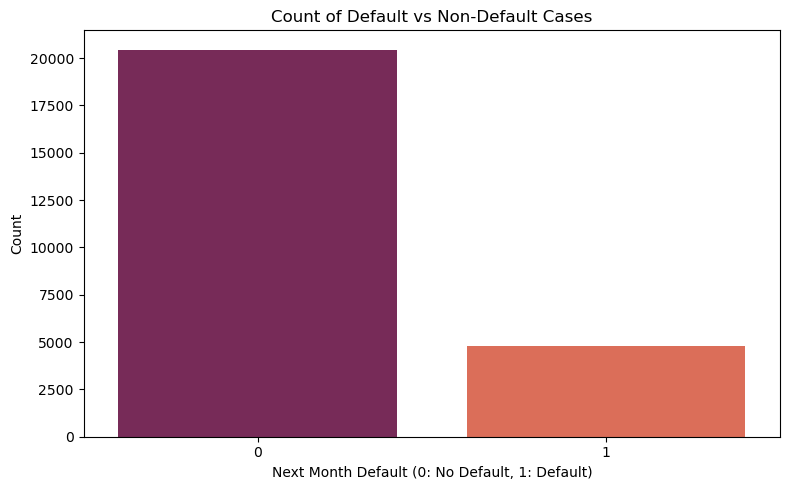

In [32]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='next_month_default', data=df, palette='rocket')
plt.title('Count of Default vs Non-Default Cases')
plt.xlabel('Next Month Default (0: No Default, 1: Default)')
plt.ylabel('Count')
plt.tight_layout()


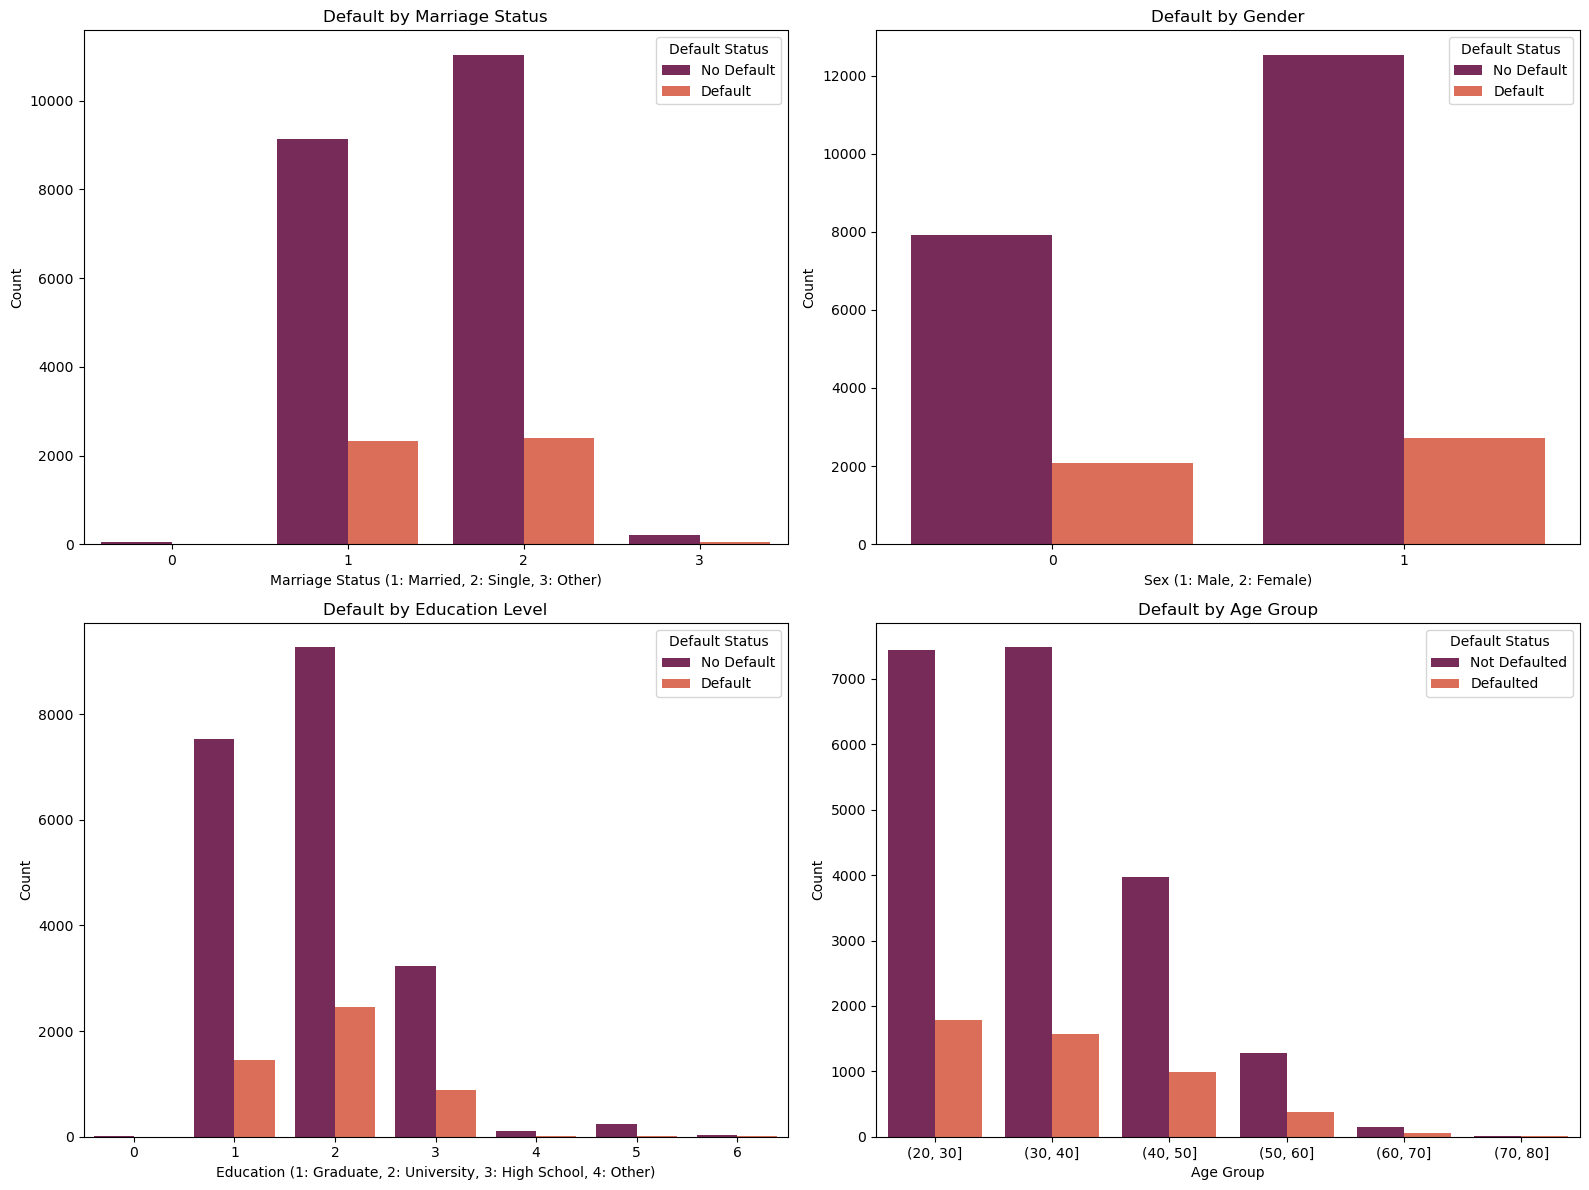

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Marriage status plot
sns.countplot(x='marriage', hue='next_month_default', data=df, ax=axes[0, 0], palette='rocket')
axes[0, 0].set_title('Default by Marriage Status')
axes[0, 0].set_xlabel('Marriage Status (1: Married, 2: Single, 3: Other)')
axes[0, 0].set_ylabel('Count')
axes[0, 0].legend(title='Default Status', labels=['No Default', 'Default'])

# Sex plot
sns.countplot(x='sex', hue='next_month_default', data=df, ax=axes[0, 1], palette='rocket')
axes[0, 1].set_title('Default by Gender')
axes[0, 1].set_xlabel('Sex (1: Male, 2: Female)')
axes[0, 1].set_ylabel('Count')
axes[0, 1].legend(title='Default Status', labels=['No Default', 'Default'])

# Education plot
sns.countplot(x='education', hue='next_month_default', data=df, ax=axes[1, 0], palette='rocket')
axes[1, 0].set_title('Default by Education Level')
axes[1, 0].set_xlabel('Education (1: Graduate, 2: University, 3: High School, 4: Other)')
axes[1, 0].set_ylabel('Count')
axes[1, 0].legend(title='Default Status', labels=['No Default', 'Default'])

# Age plot - using bins for better visualization
age_bins = [20, 30, 40, 50, 60, 70, 80]
df['age_group'] = pd.cut(df['age'], bins=age_bins)
sns.countplot(x='age_group', hue='next_month_default', data=df, ax=axes[1, 1], palette='rocket')
axes[1, 1].set_title('Default by Age Group')
axes[1, 1].set_xlabel('Age Group')
axes[1, 1].set_ylabel('Count')
axes[1, 1].legend(title='Default Status', labels=['Not Defaulted', 'Defaulted'])

plt.tight_layout()
plt.show()


Text(0, 0.5, 'Average Bill Amount')

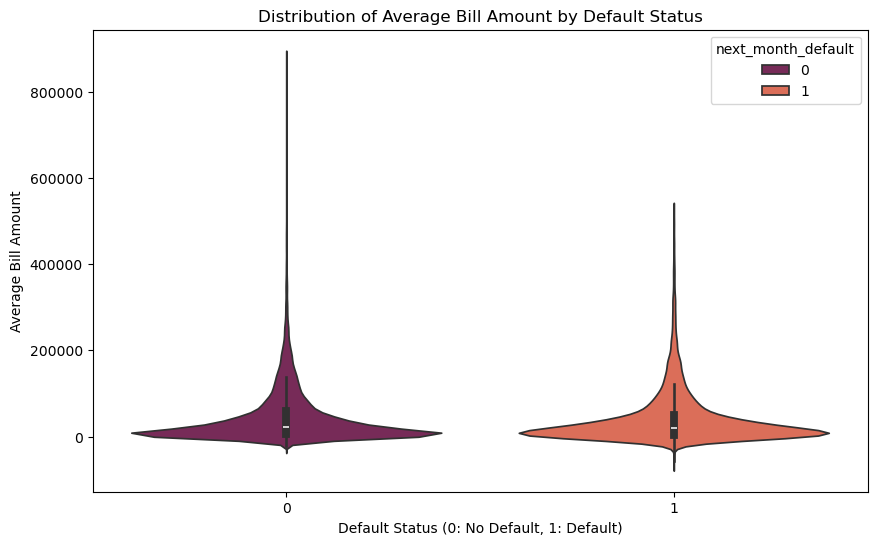

In [34]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='next_month_default', y='AVG_Bill_amt', data=df,hue='next_month_default',palette='rocket')
plt.title('Distribution of Average Bill Amount by Default Status')
plt.xlabel('Default Status (0: No Default, 1: Default)')
plt.ylabel('Average Bill Amount')

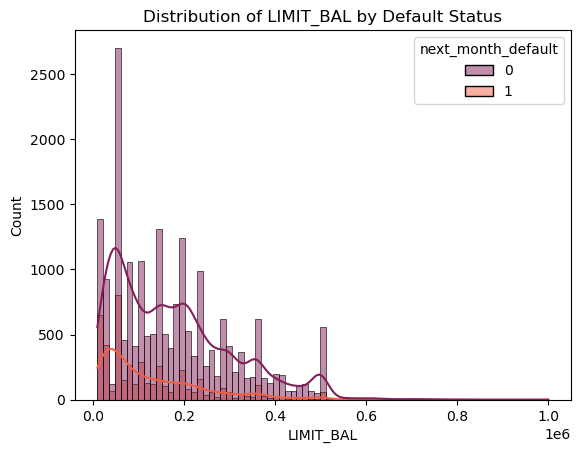

In [35]:
sns.histplot(data=df, x='LIMIT_BAL', hue='next_month_default', kde=True,palette='rocket')
plt.title('Distribution of LIMIT_BAL by Default Status')
plt.xlabel('LIMIT_BAL')
plt.ylabel('Count')
plt.show()

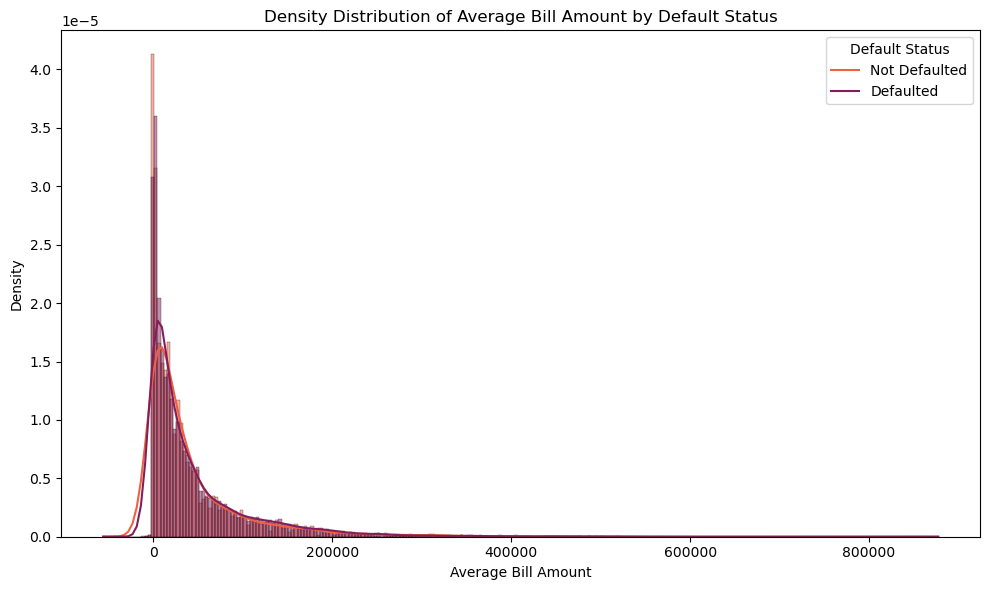

In [36]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='AVG_Bill_amt', hue='next_month_default', kde=True, stat='density', common_norm=False, palette='rocket')
plt.title('Density Distribution of Average Bill Amount by Default Status')
plt.xlabel('Average Bill Amount')
plt.ylabel('Density')
plt.legend(title='Default Status', labels=['Not Defaulted', 'Defaulted'])
plt.tight_layout()

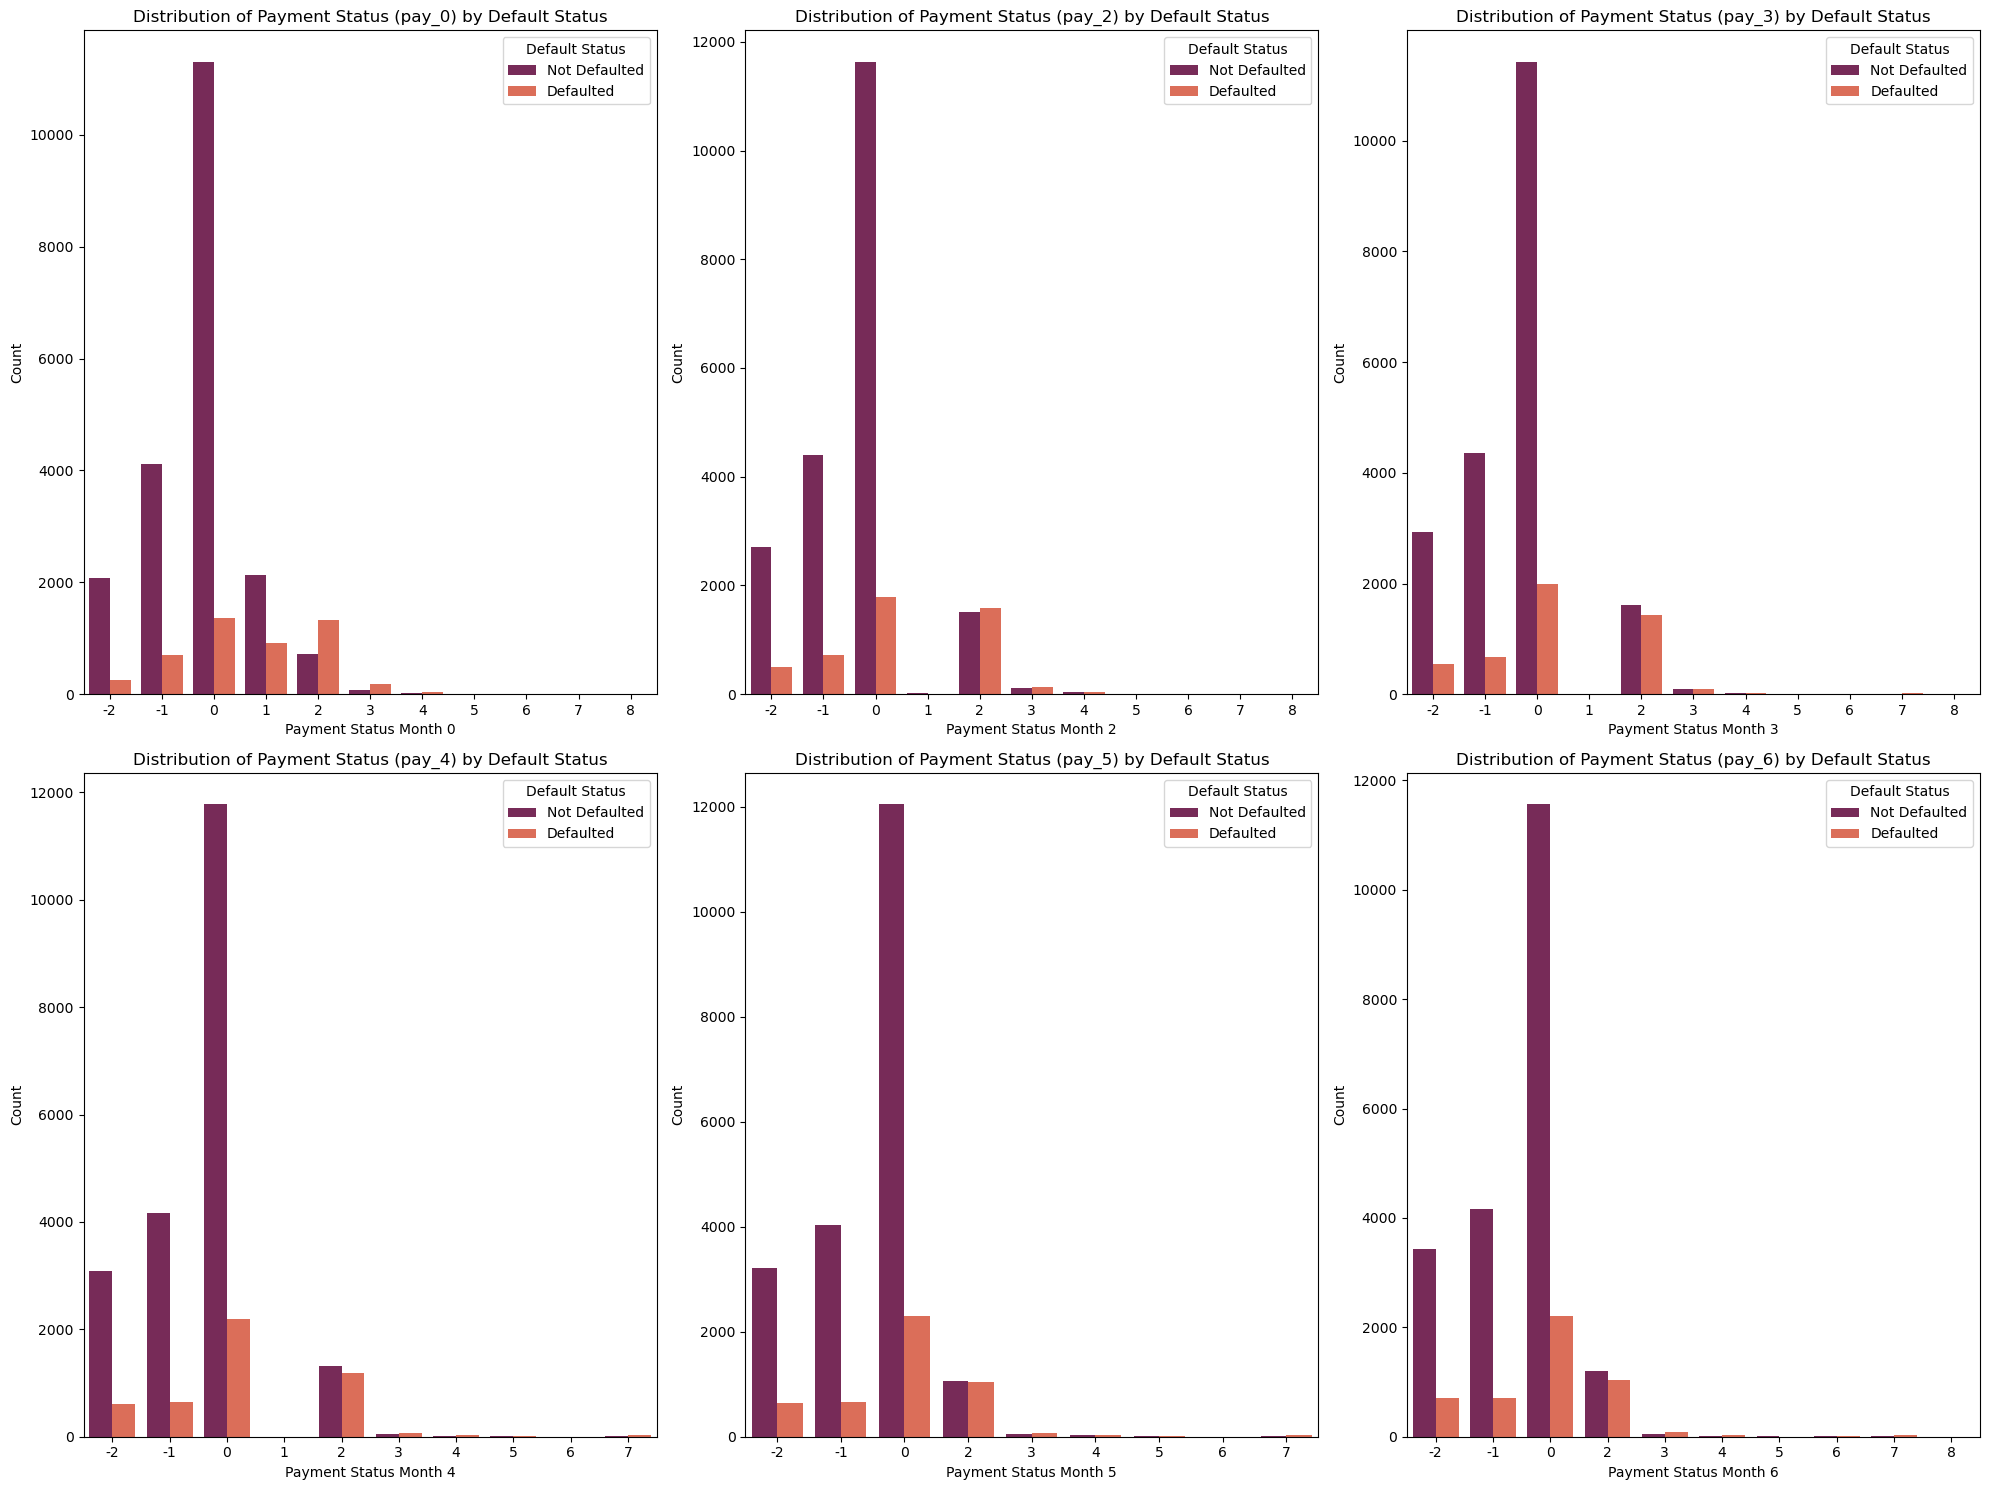

In [37]:
fig, axes = plt.subplots(2, 3, figsize=(20, 15))
axes = axes.flatten()

payment_cols = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']

for i, col in enumerate(payment_cols):
    sns.countplot(data=df, x=col, hue='next_month_default', ax=axes[i], palette='rocket')
    axes[i].set_title(f'Distribution of Payment Status ({col}) by Default Status')
    axes[i].set_xlabel(f'Payment Status Month {col[-1] if col[-1].isdigit() else "0"}')
    axes[i].set_ylabel('Count')
    axes[i].legend(title='Default Status', labels=['Not Defaulted', 'Defaulted'])
    
plt.tight_layout()
plt.show()

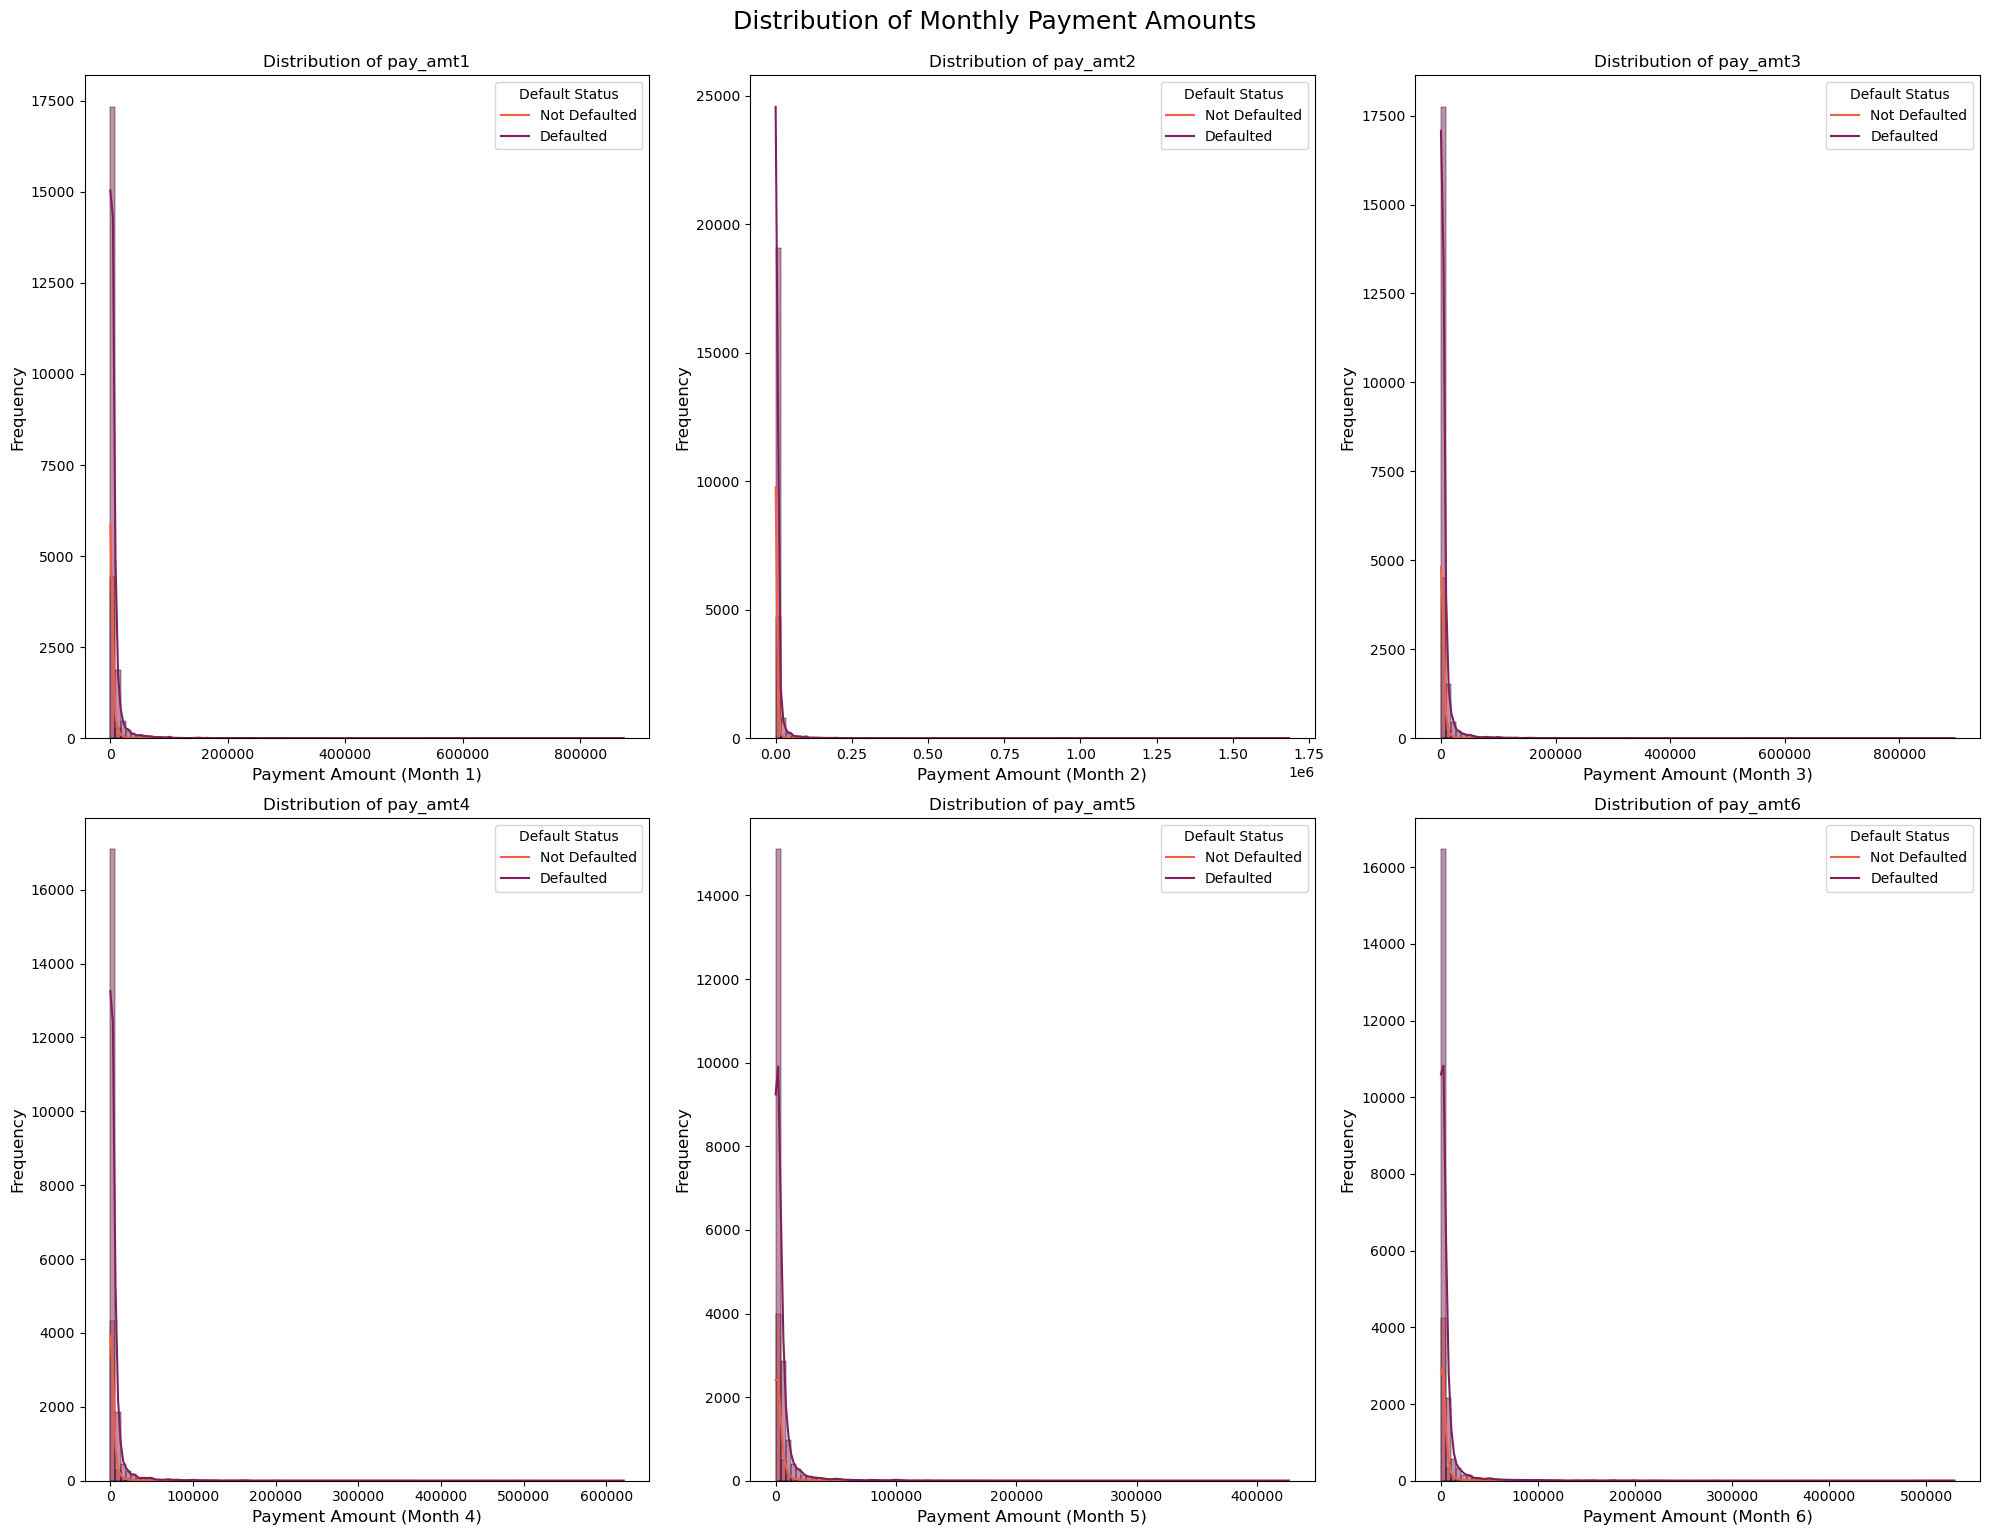

In [38]:
fig, axes = plt.subplots(2, 3, figsize=(20, 15))
axes = axes.flatten()

payment_cols = ['pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']

for i, col in enumerate(payment_cols):
    sns.histplot(data=df, x=col, hue='next_month_default', ax=axes[i], palette='rocket', kde=True, bins=100)
    
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(f'Payment Amount (Month {col[-1]})', fontsize=12) 
    axes[i].set_ylabel('Frequency', fontsize=12)
    axes[i].legend(title='Default Status', labels=['Not Defaulted', 'Defaulted'])
    
plt.tight_layout()
plt.suptitle('Distribution of Monthly Payment Amounts', fontsize=18, y=1.02)
plt.show()

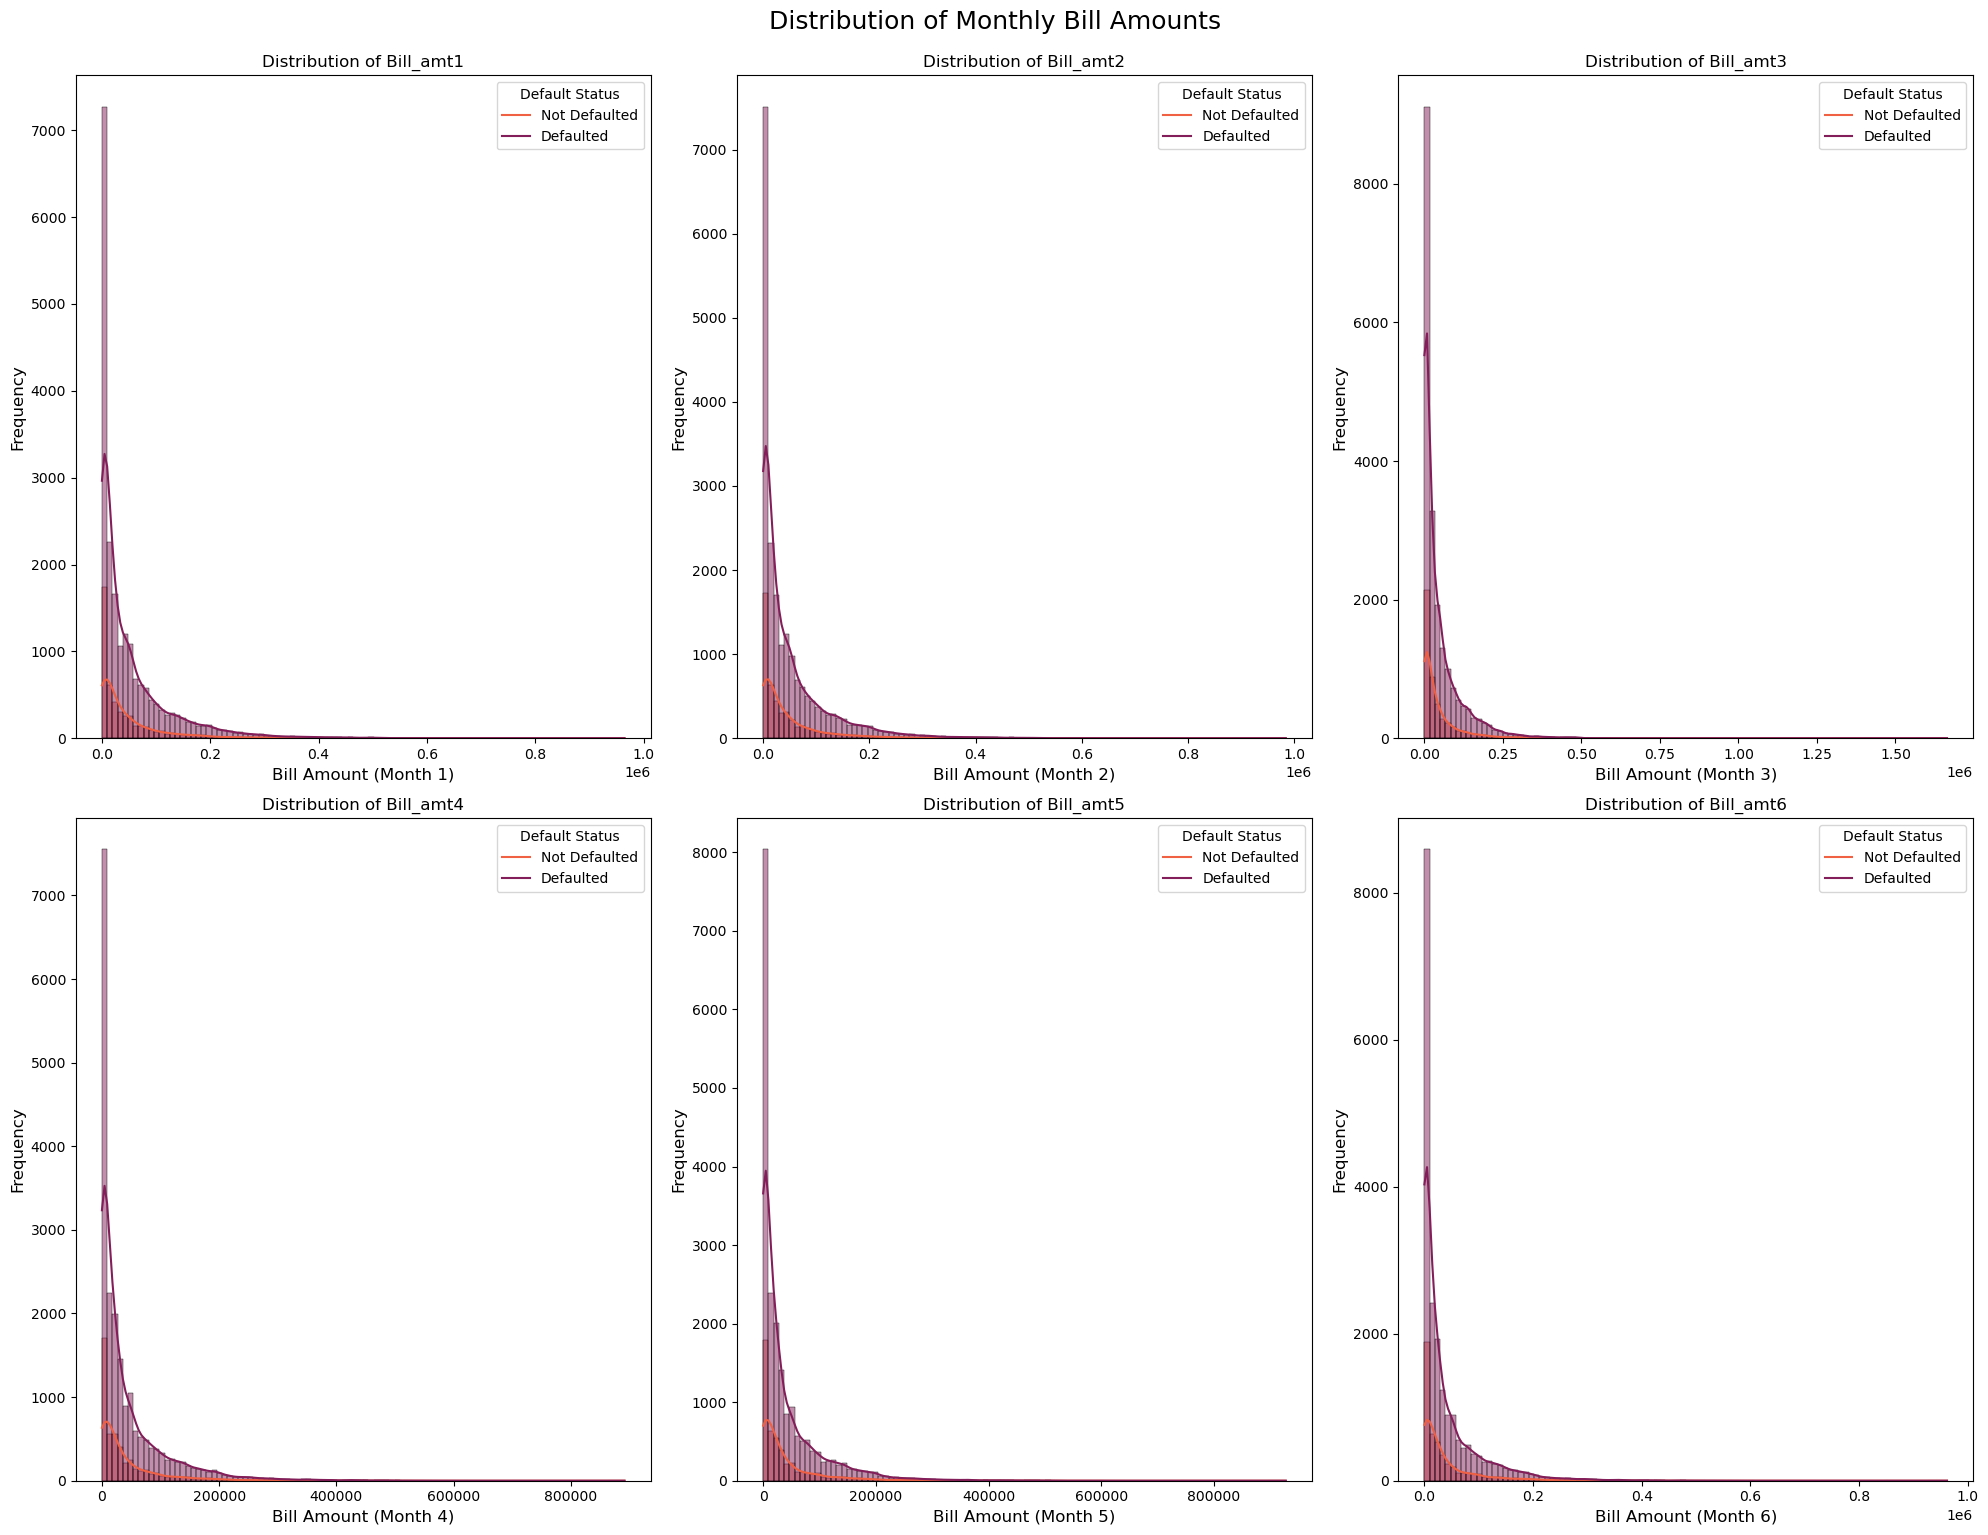

In [39]:
fig, axes = plt.subplots(2, 3, figsize=(20, 15))
axes = axes.flatten()

payment_cols = ['Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6']

for i, col in enumerate(payment_cols):
    sns.histplot(data=df, x=col, hue='next_month_default', ax=axes[i], palette='rocket', kde=True, bins=100)
    
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(f'Bill Amount (Month {col[-1]})', fontsize=12)
    axes[i].set_ylabel('Frequency', fontsize=12)
    axes[i].legend(title='Default Status', labels=['Not Defaulted', 'Defaulted'])
    
plt.tight_layout()
plt.suptitle('Distribution of Monthly Bill Amounts', fontsize=18, y=1.02)
plt.show()

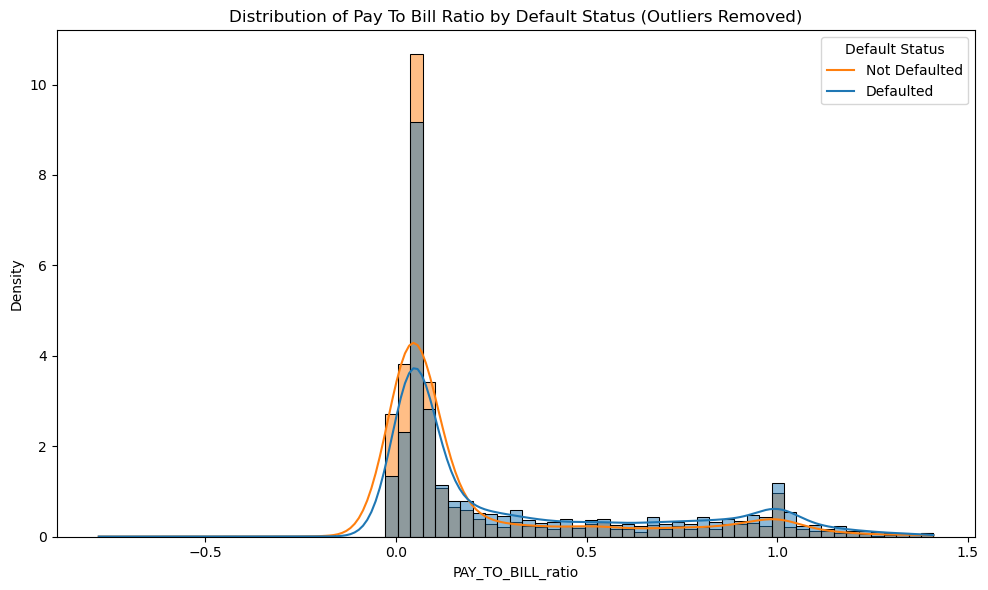

In [40]:
# Remove outliers from PAY_TO_BILL_ratio using IQR method
Q1 = df['PAY_TO_BILL_ratio'].quantile(0.25)
Q3 = df['PAY_TO_BILL_ratio'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Create filtered dataframe without outliers
df_filtered = df[(df['PAY_TO_BILL_ratio'] >= lower_bound) & (df['PAY_TO_BILL_ratio'] <= upper_bound)]

# Plot the distribution without outliers
plt.figure(figsize=(10, 6))
sns.histplot(data=df_filtered, x='PAY_TO_BILL_ratio', hue='next_month_default', 
             kde=True, stat='density', common_norm=False)
plt.title('Distribution of Pay To Bill Ratio by Default Status (Outliers Removed)')
plt.xlabel('PAY_TO_BILL_ratio')
plt.ylabel('Density')
plt.legend(title='Default Status', labels=['Not Defaulted', 'Defaulted'])
plt.tight_layout()
plt.show()

## 

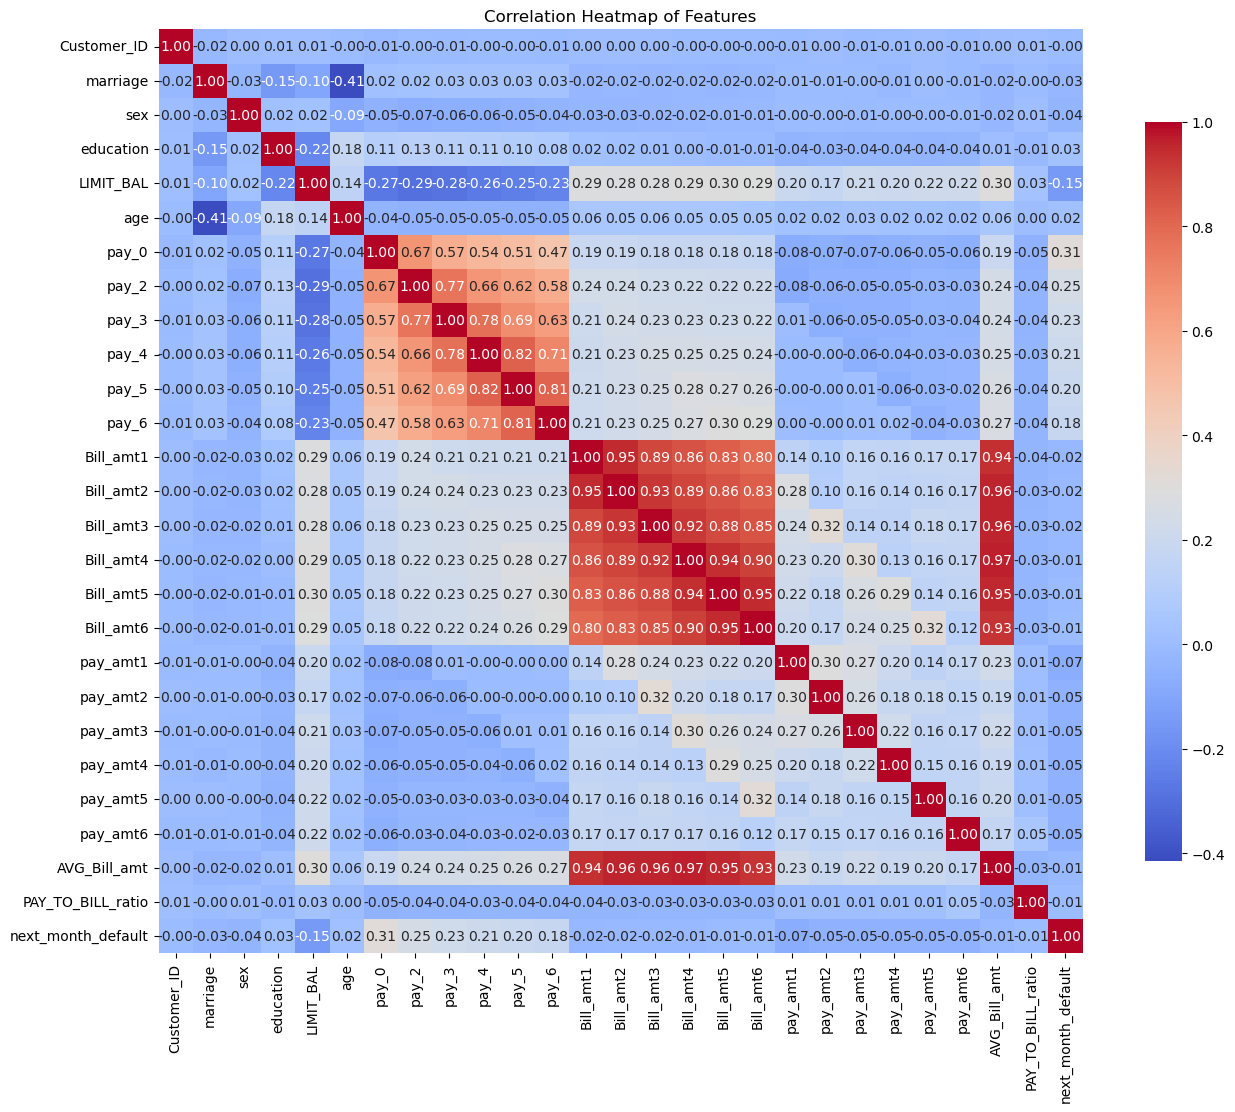

In [49]:
# I need a heatmap to visualize the correlation between features and there are only numerical features
plt.figure(figsize=(16, 12))
corr = df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap of Features')
plt.show()


#### From the above heatmap we can say that the next month default depends mainly on Payment status in previous months

## Bivariate Analysis

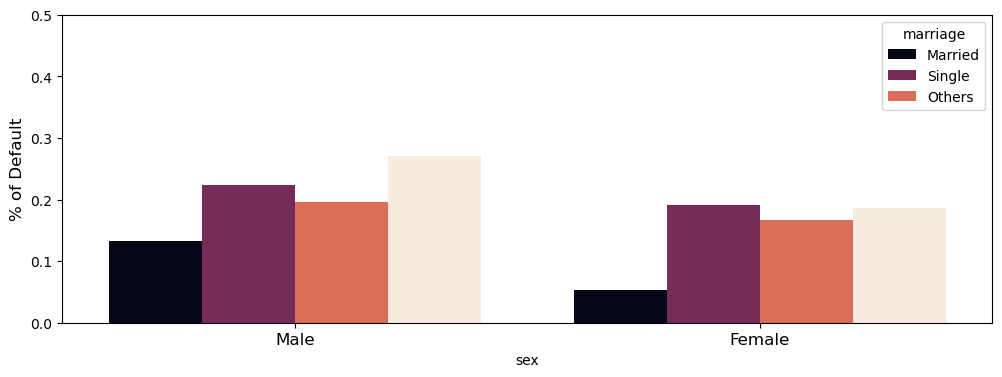

In [71]:
plt.figure(figsize=(12,4))

ax = sns.barplot(x = "sex", y = "next_month_default", hue = "marriage", data = df, palette = 'rocket', errorbar = None)

plt.ylabel("% of Default", fontsize= 12)
plt.ylim(0,0.5)
plt.xticks([0,1],['Male', 'Female'], fontsize = 12)
plt.legend(['Married', 'Single','Others'], title = 'marriage')

plt.show()

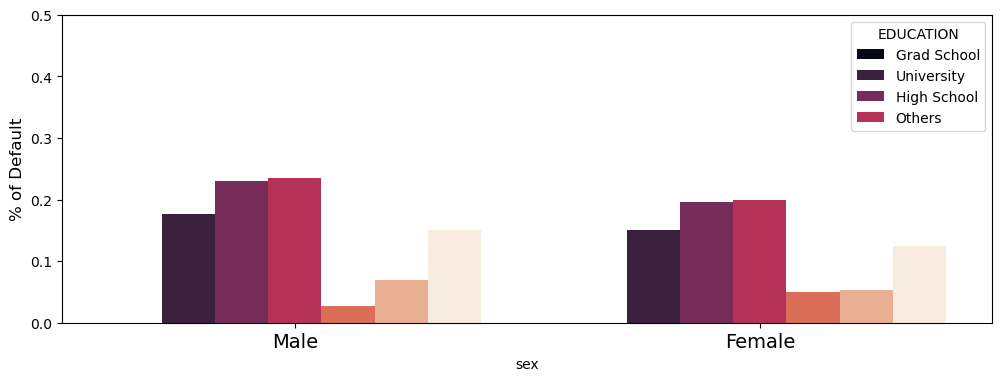

In [70]:
plt.figure(figsize=(12,4))

ax = sns.barplot(x = "sex", y = "next_month_default", hue = "education", data = df, palette = 'rocket', errorbar = None)

plt.ylabel("% of Default", fontsize= 12)
plt.ylim(0,0.5)
plt.xticks([0,1],['Male', 'Female'], fontsize = 14)
plt.legend(['Grad School', 'University', 'High School', 'Others'], title = 'EDUCATION')

plt.show()

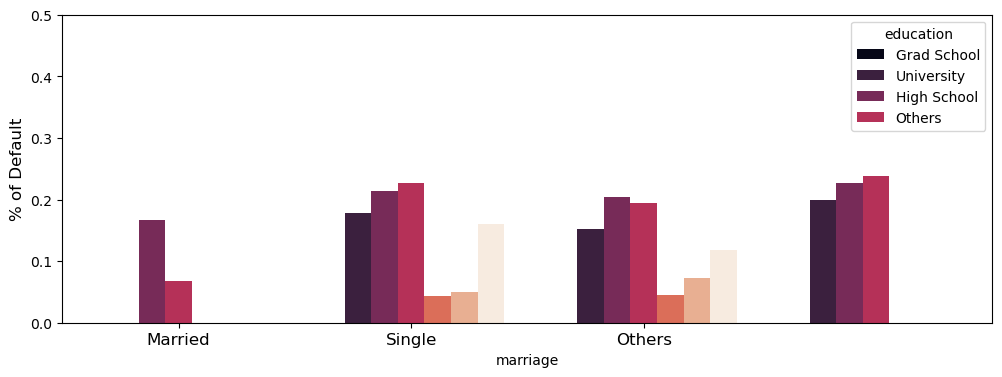

In [69]:
plt.figure(figsize=(12,4))

ax = sns.barplot(x = "marriage", y = "next_month_default", hue = "education", data = df, palette = 'rocket', errorbar = None)

plt.ylabel("% of Default", fontsize= 12)
plt.ylim(0,0.5)
plt.xticks([0,1,2],['Married', 'Single','Others'], fontsize = 12)
plt.legend(['Grad School', 'University', 'High School', 'Others'], title = 'education')


plt.show()

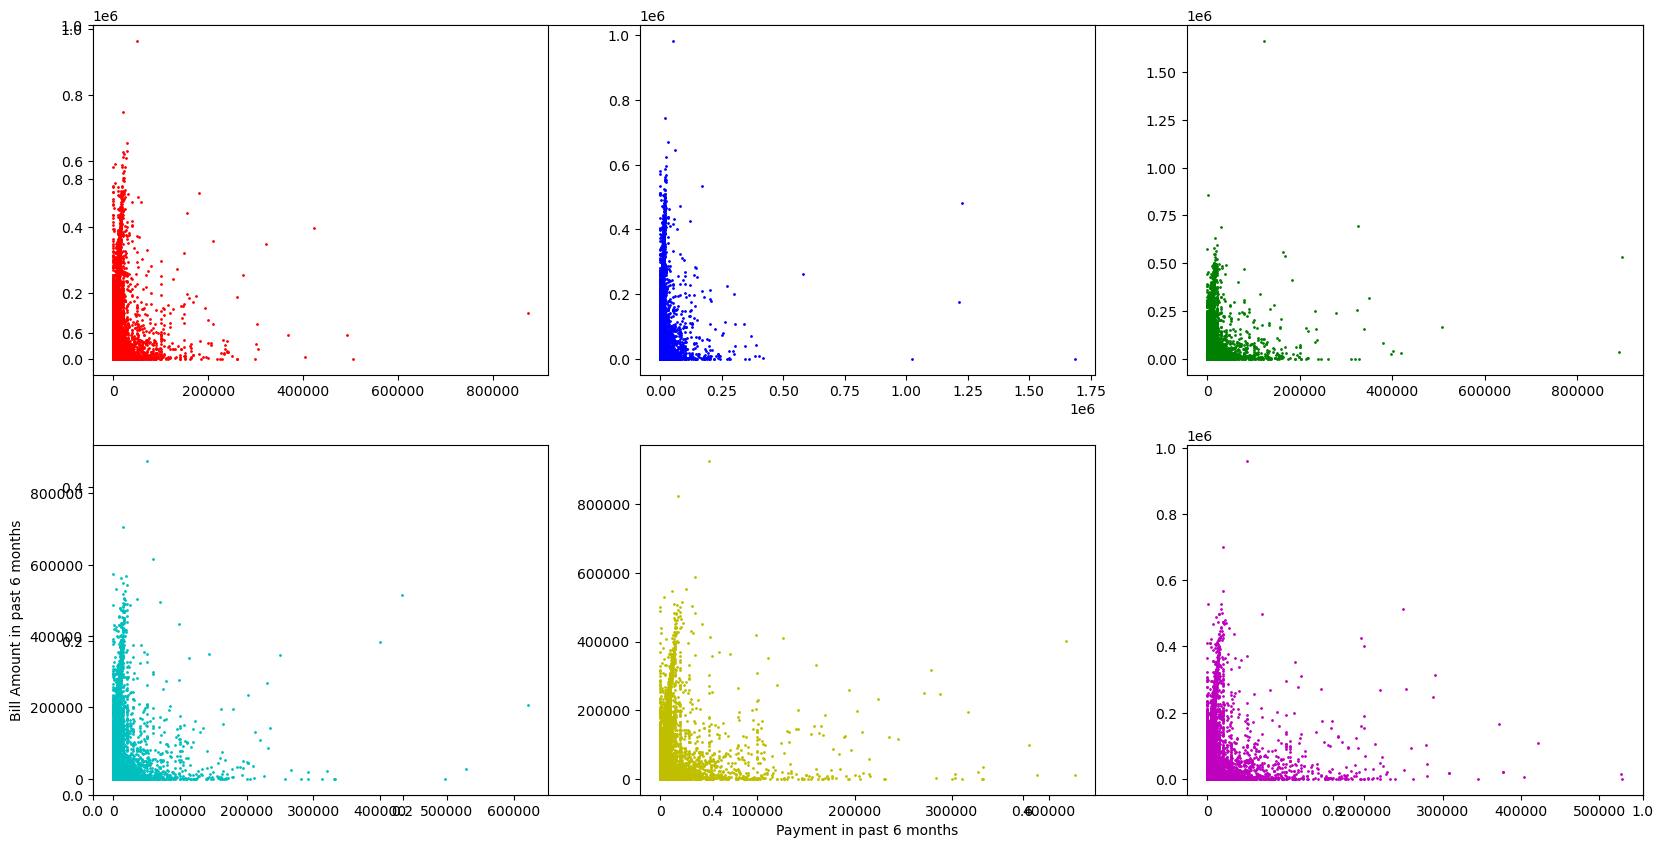

In [80]:
plt.subplots(figsize=(20,10))

plt.subplot(231)
plt.scatter(x=df.pay_amt1, y=df.Bill_amt1, c='r', s=1)

plt.subplot(232)
plt.scatter(x=df.pay_amt2, y=df.Bill_amt2, c='b', s=1)

plt.subplot(233)
plt.scatter(x=df.pay_amt3, y=df.Bill_amt3, c='g', s=1)

plt.subplot(234)
plt.scatter(x=df.pay_amt4, y=df.Bill_amt4, c='c', s=1)
plt.ylabel("Bill Amount in past 6 months")

plt.subplot(235)
plt.scatter(x=df.pay_amt5, y=df.Bill_amt5, c='y', s=1)
plt.xlabel("Payment in past 6 months")

plt.subplot(236)
plt.scatter(x=df.pay_amt6, y=df.Bill_amt6, c='m', s=1)

plt.show()